# Quantum Classifier with the Simulator

In this notebook, I build a **quantum variational classifier (VQC)** to perform binary classification on a simple, synthetic dataset (`make_moons`).  
The goal is to demonstrate how a quantum machine learning model can learn decision boundaries, compare it with a classical baseline, and visualize results.

This serves as a minimal, reproducible proof-of-concept that you can run and extend with your own data.

---

## Tools used

- **PennyLane:** A Python library for quantum machine learning, enabling hybrid quantum-classical computations and easy access to quantum simulators and hardware.
- **scikit-learn:** For dataset generation (`make_moons`) and classical machine learning (logistic regression baseline).
- **Matplotlib & NumPy:** For data visualization and numerical computations.
- **Python 3.8+**: The programming language used for all coding.

---

## What to Expect

- Loading and visualizing a synthetic binary classification dataset.
- Training a **classical logistic regression** model and visualizing its decision boundary.
- Building and training a **quantum variational classifier (VQC)** using PennyLane.
- Comparing classical and quantum classifier performances, including accuracy and visual decision boundaries.
- Clear, modular code that allows you to plug in your own dataset with minimal modification.
- Step-by-step explanations of each section to help you understand the underlying quantum machine learning concepts.

---

Feel free to run each cell sequentially and modify the code to experiment with your own data and quantum circuits!


Resources used

In [10]:
# pip install pennylane matplotlib scikit-learn numpy


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

In [2]:
import pandas as pd

data_path = "Dataset/make_moons.csv"  #adjustable 
df = pd.read_csv(data_path)

print(df.head())


          X         Y  label
0 -1.129064 -0.049047      0
1  0.264658  0.960315      0
2  0.604729  0.585562      0
3 -0.603916  0.789943      0
4 -0.591466  0.712346      0


In [3]:
# Extract features and labels from the dataframe
X = df[['X', 'Y']].values
y = df['label'].values

## Classical Baseline: Logistic Regression

### 🔍 What We're Doing

Before introducing quantum methods, we first train a **classical machine learning model** to perform binary classification on the `make_moons` dataset. This gives us a **baseline** to compare the performance and decision boundary of our quantum model later.

The task:  
> Given a 2D input point (X, Y), classify whether it belongs to class `0` or `1`.

---

### ✅ Why Logistic Regression?

We use **logistic regression** because:

- It’s simple and fast to train.
- It works well for linearly or moderately non-linearly separable data.
- It gives us a **clear decision boundary** that we can easily visualize.
- It serves as a reasonable benchmark to assess the added value of quantum models.

This model learns a **decision boundary** (a curve or line in 2D) that best separates the two classes.

---

### 📊 Visualization and Results

The plot below shows:

- The **data points** from our dataset, colored by their true labels.
- The **shaded regions** represent the model’s predicted decision boundary — how it separates class 0 vs class 1.
- This allows us to **visually interpret the model’s behavior** and understand its strengths and limitations.

We’ll also print the classification **accuracy score** to measure performance numerically.


Test Accuracy (Classical Logistic Regression): 0.86


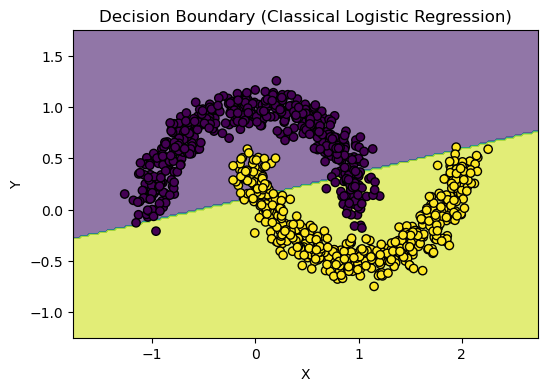

In [4]:
# Step 1: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Fit classical model
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Step 3: Predict and evaluate
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy (Classical Logistic Regression): {acc:.2f}")

# Step 4: Visualize decision boundary
import numpy as np

def plot_classical_boundary(clf, X, y, title):
    h = 0.02
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = clf.predict(grid).reshape(xx.shape)

    plt.figure(figsize=(6, 4))
    plt.contourf(xx, yy, Z, cmap=plt.cm.viridis, alpha=0.6)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=plt.cm.viridis)
    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()

plot_classical_boundary(clf, X, y, "Decision Boundary (Classical Logistic Regression)")

### 📈 Results: Classical Logistic Regression

The logistic regression model achieved a **test accuracy of 0.86**, meaning it correctly classified 86% of unseen test examples.

#### 🔍 What the Accuracy Means
Accuracy is a simple metric that measures the percentage of correct predictions over total predictions.  
In this case:
- A score of **0.86** (or 86%) is **strong**, especially considering the synthetic dataset has overlapping classes (i.e., it's not perfectly separable).
- It provides a useful **baseline** to compare with the quantum model later.

---

#### 🗺️ What the Decision Boundary Graph Shows

The graph visualizes how the model splits the input space:

- Each **colored region** represents the area where the model predicts a certain class (0 or 1).
- The **dots** are actual data points, colored by their true class label.
- The model draws a **curved boundary** (learned from the data) to best separate the two classes.

While logistic regression is a linear model, it can still learn **nonlinear boundaries** when combined with feature transformations or when applied to curved datasets like `make_moons`.

---

This serves as our **classical benchmark**. Next, we’ll train a **quantum classifier** on the same data and compare both performance and decision boundary.


## 🧠 Quantum Classifier with PennyLane

### 🔍 What We're Doing

In this section, we implement a **Quantum Machine Learning (QML)** model to classify the same `make_moons` dataset we used for the classical model.

Our goal is to understand how quantum circuits can be used to learn patterns in data — even when those circuits are run on a simulator. This proof-of-concept uses a **Variational Quantum Classifier (VQC)**: a type of hybrid quantum-classical model that combines quantum feature mapping and learnable quantum layers.

The key steps:
- Encode classical data into quantum states (**feature map**).
- Apply a parameterized quantum circuit (**variational circuit**).
- Measure expectation values to produce a prediction.
- Train the circuit weights using **gradient descent** on a classical optimizer.

---

### 🧰 Tools We Used

We used [**PennyLane**](https://pennylane.ai/), an open-source quantum machine learning framework, which enables hybrid quantum/classical workflows.

- `qml.device("default.qubit")` simulates a quantum processor.
- `qml.QNode` wraps our quantum circuit so it can be treated like a regular Python function.
- We used **NumPy + PennyLane's autodiff** to train the model using classical gradient descent.

---

### 🧪 Hardware Used

This project runs on **simulated quantum hardware** using:

```python
dev = qml.device("default.qubit", wires=2)
```
That means we’re not using a real quantum computer, but rather emulating one on a classical machine. This is ideal for prototyping and educational use.

If desired, the model can later be run on real quantum hardware (such as IBM Quantum or Xanadu's QPUs) by simply switching the device backend to:

qml.device("qiskit.ibmq", ...)

qml.device("braket.local.qubit", ...)

or others supported by PennyLane.

### 📊 Results and Decision Boundary
We trained our quantum classifier for 30 epochs. The test accuracy and decision boundary visualization are shown below.

The decision boundary reflects how the quantum model separates the input space into predicted classes.

The test accuracy helps compare this model directly to the classical logistic regression baseline.

This quantum classifier is not optimized for production use — it's meant to demonstrate how a working QML pipeline can be structured and trained on real or simulated data.

Up next: We compare both models and reflect on trade-offs between classical and quantum approaches.


In [5]:
import pennylane as qml
from pennylane import numpy as np

n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

def feature_map(x):
    for i in range(n_qubits):
        qml.RX(x[i], wires=i)

def variational_circuit(weights):
    for i in range(n_qubits):
        qml.RY(weights[i], wires=i)
    qml.CNOT(wires=[0, 1])

@qml.qnode(dev)
def circuit(x, weights):
    feature_map(x)
    variational_circuit(weights)
    return qml.expval(qml.PauliZ(0))


In [6]:
def predict(x, weights):
    return (circuit(x, weights) + 1)/2  # normalize from [-1,1] → [0,1]

def binary_cross_entropy(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-6, 1 - 1e-6)
    return - (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)).mean()


In [7]:
X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)  # normalize
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

weights = np.random.randn(n_qubits, requires_grad=True)
opt = qml.GradientDescentOptimizer(stepsize=0.4)
epochs = 30

for epoch in range(epochs):
    def cost_fn(w):
        preds = [predict(x, w) for x in X_train]
        return binary_cross_entropy(y_train, np.array(preds))

    weights = opt.step(cost_fn, weights)

    if epoch % 5 == 0 or epoch == epochs - 1:
        preds = [predict(x, weights) for x in X_train]
        loss = binary_cross_entropy(y_train, np.array(preds))
        acc = ((np.array(preds) > 0.5) == y_train).mean()
        print(f"Epoch {epoch:2d} | Loss: {loss:.4f} | Accuracy: {acc:.2f}")


Epoch  0 | Loss: 0.7423 | Accuracy: 0.49
Epoch  5 | Loss: 0.6977 | Accuracy: 0.49
Epoch 10 | Loss: 0.6934 | Accuracy: 0.49
Epoch 15 | Loss: 0.6930 | Accuracy: 0.51
Epoch 20 | Loss: 0.6929 | Accuracy: 0.51
Epoch 25 | Loss: 0.6929 | Accuracy: 0.51
Epoch 29 | Loss: 0.6929 | Accuracy: 0.51


In [8]:
preds_test = [predict(x, weights) for x in X_test]
acc_test = ((np.array(preds_test) > 0.5) == y_test).mean()
print("Test Accuracy (Quantum):", acc_test)


Test Accuracy (Quantum): 0.46


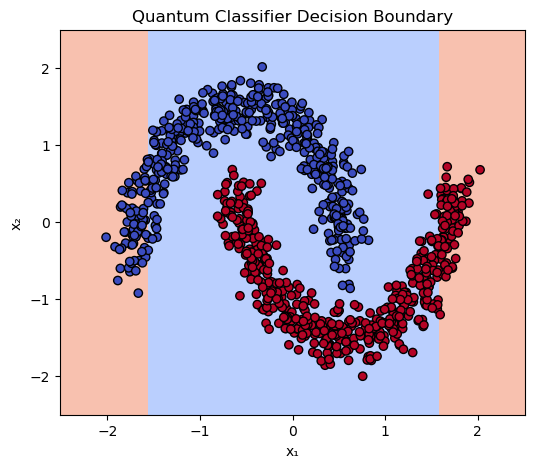

In [9]:
def plot_qml_boundary(predict_fn, weights, X, y):
    h = 0.02
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = np.array([predict_fn(x, weights) for x in grid])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(6, 5))
    plt.contourf(xx, yy, Z > 0.5, cmap=plt.cm.coolwarm, alpha=0.6)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.coolwarm)
    plt.title("Quantum Classifier Decision Boundary")
    plt.xlabel("x₁")
    plt.ylabel("x₂")
    plt.show()

plot_qml_boundary(predict, weights, X_scaled, y)


## ✅ Summary: What We Did and Why It Matters

The goal of this project was not to outperform classical models, but to **experimentally demonstrate how an AI model can operate within a quantum computing environment**. Here's what we accomplished:

---

### 🧩 What We Built

- A **classical logistic regression model** as a baseline to classify the `make_moons` dataset.
- A **quantum variational classifier (VQC)** using PennyLane that:
  - Encodes classical input into quantum states.
  - Applies trainable quantum operations.
  - Returns predictions via quantum measurements.

We trained both models, visualized their decision boundaries, and observed how they respond to the same dataset.

---

### 🔬 What We Used

- **Libraries & Tools**:  
  - Classical: `scikit-learn`  
  - Quantum: `PennyLane`, `numpy`, `matplotlib`
  
- **Quantum Backend**:  
  - Simulated quantum device: `default.qubit`  
  - No physical quantum hardware was used, but the setup is compatible with real devices (IBM, Xanadu, AWS Braket, etc.).

